[A Resnet34/50 or VGG16 backbone](https://segmentation-models.readthedocs.io/en/latest/api.html#unet) is used as the encoder part of base model (U-Net, FPN, PSPNet). Because this backbone only accept 3-channel images, 3 bands were chosen among all the 9 bands.

Bands: 


1.   NDBI （SWIR - NIR)/(SWIR + NIR)
2.   NDVI   (NIR - RED)/(NIR + RED)
3.   NDWI   (GREEN - NIR)/(GREEN + NIR)
4.   Urban or rural (used to remove chips in rural area, not for training)
5.   Blue
6.   Green
7.   Red
8.   NIR
9.   Land cover




# Data Preparation
Data preparation can be split into three steps:
 

1.   Import satellite images and corresponding masks, normalize data to the same scale, and choose the bands want to use.
2.   Create image chips: cropping satellite images into smaller regular sizes (128\*128, 256\*256, 512\*512, etc).
3.   Balance data: downsampling the images with high proportion of backgrounds.



## Import images

In [ ]:
!pip install pyrsgis
!pip install rasterio
!pip install patchify
!pip install focal-loss
!pip install segmentation_models

In [6]:
import os
import rasterio
import numpy as np
%matplotlib inline
from osgeo import gdal

# set the directory and file 
dir = '/content/drive/MyDrive/ThesisProject/Data'
image_file_name = 'bands_lst_ndbi_ndvi_ndwi_urban_r_g_b_nir_lc.tif'
park_file_name = 'park_rst.tif'

def read_file(city):  
  '''
  read the satellite image file and corresponding mask as np.array of a given city
  '''
 
  # read image file
  image_file_path = os.path.join(dir, city, image_file_name)
  image = gdal.Open(image_file_path)
  image_array = image.ReadAsArray()
  image_array = np.transpose(image_array, [1, 2, 0])  # transpose the first and third axis
  image_array[np.isnan(image_array)] = 0              # replace nan with 0
  image_array = image_array[:, :, (2, 3, 4, 9)]    # get the bands you want

  # read park file
  park_file_path = os.path.join(dir, city, park_file_name)
  park = gdal.Open(park_file_path)
  park_array = park.ReadAsArray()
  park_array = np.expand_dims(park_array, axis = 2) # expand from 2D to 3D
  park_array[np.isnan(park_array)] = 0              # replace nan with 0
  park_array[park_array > 1] = 1                    # repalce values greater than 1 with 1

  return image_array, park_array

In [ ]:
# read image and mask files of cities
image_array_SF, park_array_SF = read_file('San_Francisco')
image_array_St, park_array_St = read_file('Seattle')
image_array_Dv, park_array_Dv = read_file('Denver')
image_array_Gt, park_array_Gt = read_file('Ghent')
image_array_Ams, park_array_Ams = read_file('Amsterdam')
image_array_GM, park_array_GM = read_file('Greater_Manchester')
image_array_Dk, park_array_Dk = read_file('Dhaka')
image_array_Ph, park_array_Ph = read_file('Philadelphia')
image_array_Dbl, park_array_Dbl = read_file('Dublin')
image_array_Ld, park_array_Ld = read_file('London')
image_array_Dls, park_array_Dls = read_file('Dallas')
image_array_Vc, park_array_Vc = read_file('Vancouver')
image_array_Bf, park_array_Bf = read_file('Buffalo')

print(image_array_SF.shape, park_array_SF.shape)
print(image_array_St.shape, park_array_St.shape)
print(image_array_Dv.shape, park_array_Dv.shape)
print(image_array_Gt.shape, park_array_Gt.shape)
print(image_array_Ams.shape, park_array_Ams.shape)
print(image_array_GM.shape, park_array_GM.shape)
print(image_array_Dk.shape, park_array_Dk.shape)
print(image_array_Ph.shape, park_array_Ph.shape)
print(image_array_Dbl.shape, park_array_Dbl.shape)
print(image_array_Ld.shape, park_array_Ld.shape)
print(image_array_Dls.shape, park_array_Dls.shape)
print(image_array_Vc.shape, park_array_Vc.shape)
print(image_array_Bf.shape, park_array_Bf.shape)

(1385, 1452, 4) (1385, 1452, 1)
(2659, 1464, 4) (2659, 1464, 1)
(2532, 3576, 4) (2532, 3576, 1)
(2195, 1820, 4) (2195, 1820, 1)
(1265, 2105, 4) (1265, 2105, 1)
(3945, 4952, 4) (3945, 4952, 1)
(1891, 1053, 4) (1891, 1053, 1)
(2894, 2738, 4) (2894, 2738, 1)
(1265, 1664, 4) (1265, 1664, 1)
(4600, 5897, 4) (4600, 5897, 1)
(4454, 4063, 4) (4454, 4063, 1)
(1248, 1462, 4) (1248, 1462, 1)
(1571, 963, 4) (1571, 963, 1)


In [3]:
def normalize_by_layer(image_array):
  '''
  Function to normalize image data to the same max(1) and min(0)
  Since different layers have different scales, normalization will be done layer by layer
  '''
  for i in range(image_array.shape[2]):
    layer_min = np.min(image_array[:, :, i])
    layer_max = np.max(image_array[:, :, i])
    image_array[:, :, i] = (image_array[:, :, i] - layer_min)/(layer_max - layer_min)
  return image_array

In [ ]:
image_array_SF = normalize_by_layer(image_array_SF)
image_array_St = normalize_by_layer(image_array_St)
image_array_Dv = normalize_by_layer(image_array_Dv)
image_array_Gt = normalize_by_layer(image_array_Gt)
image_array_Ams = normalize_by_layer(image_array_Ams)
image_array_GM = normalize_by_layer(image_array_GM)
image_array_Dk = normalize_by_layer(image_array_Dk)
image_array_Ph = normalize_by_layer(image_array_Ph)
image_array_Dbl = normalize_by_layer(image_array_Dbl)
image_array_Ld = normalize_by_layer(image_array_Ld)
image_array_Dls = normalize_by_layer(image_array_Dls)
image_array_Vc = normalize_by_layer(image_array_Vc)
image_array_Bf = normalize_by_layer(image_array_Bf)

## Get image chips and balance data

In [11]:
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# define a function to crop images and corresponding masks into proper size
def create_chips(image_file, park_file, patch_size, step):
  '''
  This function creates chips for satellite image and corresponding masks
  Input  - image_file: np.array of satellite image
         - park_file: np.array of mask
         - patch_size: size of output chips
         - step: stride when cropping
  Output - one np.array for chips of satellite image, another one for mask
  '''
  
  image_dataset = []
  park_dataset = []
  patches_img = patchify(image_file, (patch_size, patch_size, image_file.shape[2]), step=step)  
  patches_prk = patchify(park_file, (patch_size, patch_size, park_file.shape[2]), step=step)
  
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i,j,:,:]   
      single_patch_img = single_patch_img[0] # Drop the extra unecessary dimension that patchify adds. 
      
      single_patch_prk = patches_prk[i,j,:,:]   
      single_patch_prk = single_patch_prk[0]
      
      if np.count_nonzero(single_patch_img[:, :, 2] == 1) > 0.5 * single_patch_img[:, :, 2].size:
        image_dataset.append(single_patch_img[:, :, (0, 1, 3)]) 
        park_dataset.append(single_patch_prk)
  image_dataset = np.array(image_dataset)
  park_dataset = np.array(park_dataset)

  return image_dataset, park_dataset

In [ ]:
def remove_images(image_dataset, park_dataset, threshold):
  '''
  This function remove images and corresponding masks with high proportion of backgrounds
  Input  - image_dataset, park_dataset: np.array of chips of satellite images and masks
         - threshold: if proportion of backgrounds is higher than threshold, the chips will be removed
  Output - balanced array without those chips
  '''
  
  # get the id of images to remove
  id_to_remove = []
  for i in range(len(park_dataset)):
    mask = park_dataset[i, :, :, 0]
    tot_pixel = mask.size
    background_pixel = np.count_nonzero(mask == 0)
    if background_pixel > tot_pixel * threshold:
      id_to_remove.append(i)
  
  # get the balanced dataset
  image_dataset_balanced = []
  park_dataset_balanced = []
  for i in range(len(image_dataset)):
    if not(i in id_to_remove):
      image = image_dataset[i]
      park = park_dataset[i]
      image_dataset_balanced.append(image)
      park_dataset_balanced.append(park)
  image_dataset_balanced = np.array(image_dataset_balanced)
  park_dataset_balanced = np.array(park_dataset_balanced)

  return image_dataset_balanced, park_dataset_balanced

In [ ]:
# get the balanced dataset of cities
image_dataset_SF, park_dataset_SF = create_chips(image_array_SF, park_array_SF, patch_size=256, step=32)
image_dataset_SF_balanced, park_dataset_SF_balanced = remove_images(image_dataset_SF, park_dataset_SF, 0.86)
del image_dataset_SF, park_dataset_SF
print(image_dataset_SF_balanced.shape, park_dataset_SF_balanced.shape)

image_dataset_St, park_dataset_St = create_chips(image_array_St, park_array_St, patch_size=256, step=32)
image_dataset_St_balanced, park_dataset_St_balanced = remove_images(image_dataset_St, park_dataset_St, 0.86)
del image_dataset_St, park_dataset_St
print(image_dataset_St_balanced.shape, park_dataset_St_balanced.shape)

image_dataset_Dv, park_dataset_Dv = create_chips(image_array_Dv, park_array_Dv, patch_size=256, step=32)
image_dataset_Dv_balanced, park_dataset_Dv_balanced = remove_images(image_dataset_Dv, park_dataset_Dv, 0.86)
del image_dataset_Dv, park_dataset_Dv
print(image_dataset_Dv_balanced.shape, park_dataset_Dv_balanced.shape)

image_dataset_Gt, park_dataset_Gt = create_chips(image_array_Gt, park_array_Gt, patch_size=256, step=32)
image_dataset_Gt_balanced, park_dataset_Gt_balanced = remove_images(image_dataset_Gt, park_dataset_Gt, 0.86)
del image_dataset_Gt, park_dataset_Gt
print(image_dataset_Gt_balanced.shape, park_dataset_Gt_balanced.shape)

image_dataset_Ams, park_dataset_Ams = create_chips(image_array_Ams, park_array_Ams, patch_size=256, step=32)
image_dataset_Ams_balanced, park_dataset_Ams_balanced = remove_images(image_dataset_Ams, park_dataset_Ams, 0.86)
del image_dataset_Ams, park_dataset_Ams
print(image_dataset_Ams_balanced.shape, park_dataset_Ams_balanced.shape)

image_dataset_GM, park_dataset_GM = create_chips(image_array_GM, park_array_GM, patch_size=256, step=64)
image_dataset_GM_balanced, park_dataset_GM_balanced = remove_images(image_dataset_GM, park_dataset_GM, 0.86)
del image_dataset_GM, park_dataset_GM
print(image_dataset_GM_balanced.shape, park_dataset_GM_balanced.shape)

image_dataset_Dk, park_dataset_Dk = create_chips(image_array_Dk, park_array_Dk, patch_size=256, step=32)
image_dataset_Dk_balanced, park_dataset_Dk_balanced = remove_images(image_dataset_Dk, park_dataset_Dk, 0.9)
del image_dataset_Dk, park_dataset_Dk
print(image_dataset_Dk_balanced.shape, park_dataset_Dk_balanced.shape)

image_dataset_Ph, park_dataset_Ph = create_chips(image_array_Ph, park_array_Ph, patch_size=256, step=32)
image_dataset_Ph_balanced, park_dataset_Ph_balanced = remove_images(image_dataset_Ph, park_dataset_Ph, 0.86)
del image_dataset_Ph, park_dataset_Ph
print(image_dataset_Ph_balanced.shape, park_dataset_Ph_balanced.shape)

image_dataset_Dbl, park_dataset_Dbl = create_chips(image_array_Dbl, park_array_Dbl, patch_size=256, step=32)
image_dataset_Dbl_balanced, park_dataset_Dbl_balanced = remove_images(image_dataset_Dbl, park_dataset_Dbl, 0.86)
del image_dataset_Dbl, park_dataset_Dbl
print(image_dataset_Dbl_balanced.shape, park_dataset_Dbl_balanced.shape)

image_dataset_Ld, park_dataset_Ld = create_chips(image_array_Ld, park_array_Ld, patch_size=256, step=80)
image_dataset_Ld_balanced, park_dataset_Ld_balanced = remove_images(image_dataset_Ld, park_dataset_Ld, 0.86)
del image_dataset_Ld, park_dataset_Ld
print(image_dataset_Ld_balanced.shape, park_dataset_Ld_balanced.shape)

image_dataset_Dls, park_dataset_Dls = create_chips(image_array_Dls, park_array_Dls, patch_size=256, step=80)
image_dataset_Dls_balanced, park_dataset_Dls_balanced = remove_images(image_dataset_Dls, park_dataset_Dls, 0.86)
del image_dataset_Dls, park_dataset_Dls
print(image_dataset_Dls_balanced.shape, park_dataset_Dls_balanced.shape)

image_dataset_Vc, park_dataset_Vc = create_chips(image_array_Vc, park_array_Vc, patch_size=256, step=32)
image_dataset_Vc_balanced, park_dataset_Vc_balanced = remove_images(image_dataset_Vc, park_dataset_Vc, 0.86)
del image_dataset_Vc, park_dataset_Vc
print(image_dataset_Vc_balanced.shape, park_dataset_Vc_balanced.shape)

image_dataset_Bf, park_dataset_Bf = create_chips(image_array_Bf, park_array_Bf, patch_size=256, step=32)
image_dataset_Bf_balanced, park_dataset_Bf_balanced = remove_images(image_dataset_Bf, park_dataset_Bf, 0.86)
del image_dataset_Bf, park_dataset_Bf
print(image_dataset_Bf_balanced.shape, park_dataset_Bf_balanced.shape)

(388, 256, 256, 3) (388, 256, 256, 1)
(323, 256, 256, 3) (323, 256, 256, 1)
(486, 256, 256, 3) (486, 256, 256, 1)
(132, 256, 256, 3) (132, 256, 256, 1)
(219, 256, 256, 3) (219, 256, 256, 1)
(605, 256, 256, 3) (605, 256, 256, 1)
(26, 256, 256, 3) (26, 256, 256, 1)
(1048, 256, 256, 3) (1048, 256, 256, 1)
(293, 256, 256, 3) (293, 256, 256, 1)
(316, 256, 256, 3) (316, 256, 256, 1)
(224, 256, 256, 3) (224, 256, 256, 1)
(87, 256, 256, 3) (87, 256, 256, 1)
(152, 256, 256, 3) (152, 256, 256, 1)


In [ ]:
# pool cities together
image_dataset = np.concatenate([image_dataset_St_balanced, image_dataset_Dv_balanced, 
                                image_dataset_Gt_balanced, image_dataset_Ams_balanced,
                                image_dataset_GM_balanced, image_dataset_SF_balanced,
                                image_dataset_Dk_balanced, image_dataset_Ph_balanced,
                                image_dataset_Dbl_balanced, image_dataset_Ld_balanced,
                                image_dataset_Dls_balanced, image_dataset_Vc_balanced,
                                image_dataset_Bf_balanced], axis = 0)
print(image_dataset.shape)
del image_dataset_St_balanced, image_dataset_Dv_balanced
del image_dataset_Gt_balanced, image_dataset_Ams_balanced
del image_dataset_GM_balanced, image_dataset_SF_balanced, image_dataset_Bf_balanced
del image_dataset_Dk_balanced, image_dataset_Ph_balanced, image_dataset_Vc_balanced
del image_dataset_Dbl_balanced, image_dataset_Ld_balanced, image_dataset_Dls_balanced

park_dataset = np.concatenate([park_dataset_St_balanced, park_dataset_Dv_balanced, 
                               park_dataset_Gt_balanced, park_dataset_Ams_balanced,
                               park_dataset_GM_balanced, park_dataset_SF_balanced,
                               park_dataset_Dk_balanced, park_dataset_Ph_balanced,
                               park_dataset_Dbl_balanced, park_dataset_Ld_balanced,
                               park_dataset_Dls_balanced, park_dataset_Vc_balanced,
                               park_dataset_Bf_balanced], axis = 0)
print(park_dataset.shape)
del park_dataset_St_balanced, park_dataset_Dv_balanced
del park_dataset_Gt_balanced, park_dataset_Ams_balanced
del park_dataset_GM_balanced, park_dataset_SF_balanced
del park_dataset_Dk_balanced, park_dataset_Ph_balanced, park_dataset_Dbl_balanced, park_dataset_Ld_balanced
del park_dataset_Dls_balanced, park_dataset_Vc_balanced, park_dataset_Bf_balanced

(4299, 256, 256, 3)
(4299, 256, 256, 1)


In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", park_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Min pixel value in image is: ", image_dataset.min())
print("Labels in the mask are : ", np.unique(park_dataset))
print("Number of cell with value 1: ", np.count_nonzero(park_dataset == 1))
print("Number of cell with value 0: ", np.count_nonzero(park_dataset == 0))

Image data shape is:  (4299, 256, 256, 3)
Mask data shape is:  (4299, 256, 256, 1)
Max pixel value in image is:  1.0
Min pixel value in image is:  0.0
Labels in the mask are :  [0. 1.]
Number of cell with value 1:  71868840
Number of cell with value 0:  209870424


# Build training and test set

## Split and preprocess to fit model architecture

In [ ]:
# train-validation-test split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, park_dataset, 
                                                    test_size = 0.15, random_state = 42)

del image_dataset, park_dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3654, 256, 256, 3) (645, 256, 256, 3)
(3654, 256, 256, 1) (645, 256, 256, 1)


In [ ]:
# preprocess input to fit model architecture
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import keras
import tensorflow
from keras.layers import Input, Conv2D
from keras.models import Model

BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE) # get the preprocessing function
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)
print(X_train.shape, X_test.shape)

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
(3654, 256, 256, 3) (645, 256, 256, 3)


In [ ]:
# turn park_dataset into categorical (one-hot encoding to fit the model architecture)
from tensorflow.keras.utils import to_categorical

# y_train
train_masks_cat = to_categorical(y_train, num_classes=2)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 2))

# y_test
test_masks_cat = to_categorical(y_test, num_classes=2)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], 2))

print(y_train_cat.shape, y_test_cat.shape)

(3654, 256, 256, 2) (645, 256, 256, 2)


## Data augmentation
Data augmentation was performed to expand image dataset and to reduce overfitting. The techniques chosen were rotation, flip, and shift.

In [ ]:
# set parameters of data augmentation
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=45, 
                         width_shift_range=0.2, 
                         height_shift_range=0.2, 
                         zoom_range=0.2, 
                         horizontal_flip=True, 
                         vertical_flip=True, 
                         fill_mode='reflect',
                         preprocessing_function = preprocess_input)

mask_data_gen_args = dict(rotation_range=45, 
                          width_shift_range=0.2, 
                          height_shift_range=0.2, 
                          zoom_range=0.2, 
                          horizontal_flip=True, 
                          vertical_flip=True, 
                          fill_mode='reflect',
                          preprocessing_function = lambda x: np.where(x > 0, 1, 0).astype(x.dtype)) 

# set the batch size of image generator
batch_size= 16

# image generator (X_train and X_test)
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size) 

# mask generator (y_train and y_test)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train_cat, augment=True, seed=seed)

mask_generator = mask_data_generator.flow(y_train_cat, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test_cat, seed=seed, batch_size=batch_size)

# put image generator and mask generator together
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

train_generator = my_image_mask_generator(image_generator, mask_generator)
validation_generator = my_image_mask_generator(valid_img_generator, valid_mask_generator)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (3654, 256, 256, 2) (2 channels).
  ' channels).')
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (3654, 256, 256, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 chann

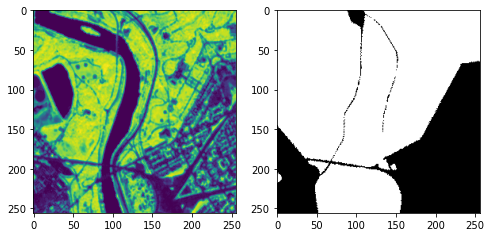

In [ ]:
# sanity check
import matplotlib.pyplot as plt

x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    plt.figure(figsize=(8, 4))
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(normalize_by_layer(image)[:, :, 0])
    
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,1], cmap = 'gray')
    plt.show()

# Model training and evaluation

## Model build and training

In [ ]:
# build model (U-Net with resnet50 backbone, pretrained on imagenet)
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import keras
import tensorflow
from keras.layers import Input, Conv2D
from keras.models import Model

sm.set_framework('tf.keras')
sm.framework()

n_classes = 2
activation = 'sigmoid'  # the activation function used for the output layer

# set loss function and metrics
LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)
loss = sm.losses.binary_focal_dice_loss
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# set BACKBONE
BACKBONE = 'resnet50'

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape = (256, 256, 3),
                classes=n_classes, activation=activation, decoder_filters=(1024, 512, 256, 128, 64))

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, loss = loss, metrics=metrics)
#model.summary()

env: SM_FRAMEWORK=tf.keras
94601216/94592056 [==============================] - 3s 0us/step


In [ ]:
# set hyperparameters
batch_size = 16
steps_per_epoch = len(X_train)//batch_size  # for generator, you need to specify the steps if using generator
validation_steps = len(X_test)//batch_size  # for generator
print(steps_per_epoch, validation_steps)

228 40


Epoch 1/50
228/228 [==============================] - 252s 968ms/step - loss: 0.3312 - accuracy: 0.8467 - iou_score: 0.6836 - f1-score: 0.8004 - val_loss: 0.6631 - val_accuracy: 0.5752 - val_iou_score: 0.3621 - val_f1-score: 0.5084
Epoch 2/50
228/228 [==============================] - 211s 925ms/step - loss: 0.2506 - accuracy: 0.8905 - iou_score: 0.7552 - f1-score: 0.8554 - val_loss: 0.6467 - val_accuracy: 0.7648 - val_iou_score: 0.3842 - val_f1-score: 0.4368
Epoch 3/50
228/228 [==============================] - 211s 927ms/step - loss: 0.2197 - accuracy: 0.9068 - iou_score: 0.7840 - f1-score: 0.8749 - val_loss: 1.6088 - val_accuracy: 0.2483 - val_iou_score: 0.1410 - val_f1-score: 0.2257
Epoch 4/50
228/228 [==============================] - 211s 927ms/step - loss: 0.2024 - accuracy: 0.9151 - iou_score: 0.8001 - f1-score: 0.8854 - val_loss: 1.4777 - val_accuracy: 0.4304 - val_iou_score: 0.2750 - val_f1-score: 0.4272
Epoch 5/50
228/228 [==============================] - 211s 926ms/step - 

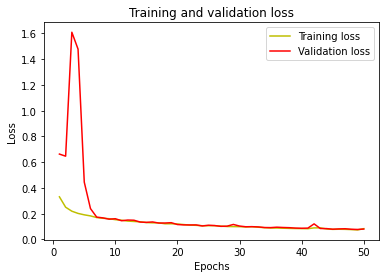

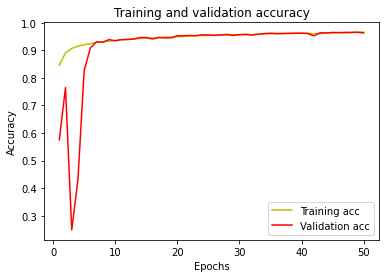

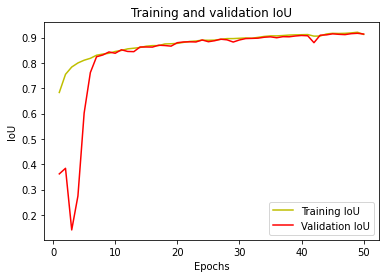

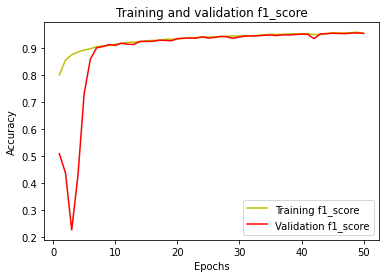

In [ ]:
# model training (with data augmentation)
history1 = model.fit(train_generator, batch_size=batch_size, epochs=50,  steps_per_epoch = steps_per_epoch,
                     validation_steps = validation_steps, verbose=1, validation_data = validation_generator)

# plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt

loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
IoU = history1.history['iou_score']
val_IoU = history1.history['val_iou_score']
epochs = range(1, len(IoU) + 1)
plt.plot(epochs, IoU, 'y', label='Training IoU')
plt.plot(epochs, val_IoU, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

f1_score = history1.history['f1-score']
val_f1_score = history1.history['val_f1-score']
plt.plot(epochs, f1_score, 'y', label='Training f1_score')
plt.plot(epochs, val_f1_score, 'r', label='Validation f1_score')
plt.title('Training and validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# save model
model.save('/content/drive/MyDrive/ThesisProject/model-Unetresnet50-ndvirnir.h5')

## Evaluation on validation set

In [ ]:
# Metrics
loss, acc, IoU, f_score = model.evaluate(X_test, y_test_cat, verbose = 0)

print("Loss is ", loss)
print("Accuracy is ", acc)
print("IoU is ", IoU)
print("f_score is ", f_score)

Loss is  0.0784190446138382
Accuracy is  0.9709136486053467
IoU is  0.9223220348358154
f_score is  0.9591103792190552


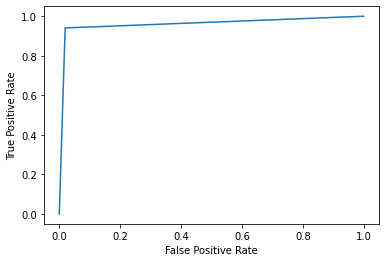

AUC is  0.960800723685774


In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve

# get prediction for test set
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3) # get the max value of the 4th axis, because of one-hot encoding
y_test_cat_argmax = np.argmax(y_test_cat, axis=3)  # get the max of the 4th axis of y_test_cat

# change to binary type
y_pred_argmax_raveled = y_pred_argmax.ravel()  # before set type, flatten the array first
y_test_cat_argmax_raveled = y_test_cat_argmax.ravel()

y_pred_argmax_raveled = y_pred_argmax_raveled.astype(int)
y_test_cat_argmax_raveled = y_test_cat_argmax_raveled.astype(int)

FPR, TPR, thresholds = roc_curve(y_test_cat_argmax_raveled, y_pred_argmax_raveled)

# create ROC curve and AUC
plt.plot(FPR,TPR)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

from sklearn.metrics import auc
auc = auc(FPR, TPR)
print("AUC is ", auc)

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test_cat_argmax_raveled, y_pred_argmax_raveled)
recall = recall_score(y_test_cat_argmax_raveled, y_pred_argmax_raveled)

print("Precision is", precision)
print("Recall is ", recall)

Precision is 0.9464990501920224
Recall is  0.9172187023199098


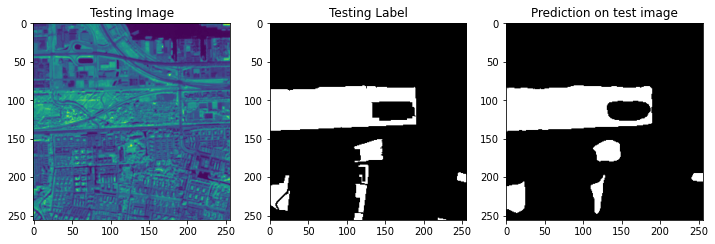

In [ ]:
# Test some random images
import random

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input(test_img_input)

test_pred1 = model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:, :, 2])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()

# Test on a new city

In [7]:
# import datasets, create chips, and remove samples with high proportion of backgrounds
dir = '/content/drive/MyDrive/ThesisProject/Data'
image_file_name = 'bands_lst_ndbi_ndvi_ndwi_urban_r_g_b_nir_lc.tif'
park_file_name = 'park_rst.tif'

image_array, park_array = read_file('TelAviv')
image_array = normalize_by_layer(image_array)
print(image_array.shape, park_array.shape)

(1293, 980, 4) (1293, 980, 1)


In [8]:
image_array = image_array[0:image_array.shape[0]//256 * 256, 0:image_array.shape[1]//256 * 256, :]
park_array = park_array[0:park_array.shape[0]//256 * 256, 0:park_array.shape[1]//256 * 256, :]
print(image_array.shape)

(1280, 768, 4)


In [12]:
image_dataset, park_dataset = create_chips(image_array, park_array, patch_size=256, step=64)
print(image_dataset.shape, park_dataset.shape)

(111, 256, 256, 3) (111, 256, 256, 1)


In [10]:
# load model
from keras.models import load_model
import tensorflow
import segmentation_models as sm

model = load_model('/content/drive/MyDrive/ThesisProject/model-Unetresnet50-ndvindwilc.h5', 
                   compile = False)

# compile model
LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)
loss = sm.losses.binary_focal_dice_loss 
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(optim, loss, metrics=metrics)

Segmentation Models: using `keras` framework.


In [13]:
# precessing X to fit the model
import segmentation_models as sm
from tensorflow.keras.utils import to_categorical

BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)
X_test = preprocess_input(image_dataset)

# turn y to categorical data
test_masks_cat = to_categorical(park_dataset, num_classes=2)
y_test_cat = test_masks_cat.reshape((park_dataset.shape[0], 
                                     park_dataset.shape[1], 
                                     park_dataset.shape[2], 2))
print(X_test.shape, y_test_cat.shape)

(111, 256, 256, 3) (111, 256, 256, 2)


In [ ]:
# predict and metrics
loss, acc, IoU, f_score = model.evaluate(X_test, y_test_cat, verbose = 0)

print("Loss is ", loss)
print("Accuracy is ", acc)
print("IoU is ", IoU)
print("f_score is ", f_score)

Loss is  0.4410892128944397
Accuracy is  0.8775815367698669
IoU is  0.652915894985199
f_score is  0.7601285576820374


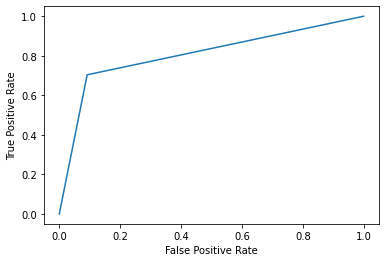

AUC is  0.8061030750984073


In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve

# get prediction for test set
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3) # get the max value of the 4th axis, because of one-hot encoding
y_test_cat_argmax = np.argmax(y_test_cat, axis=3)  # get the max of the 4th axis of y_test_cat

# change to binary type
y_pred_argmax_raveled = y_pred_argmax.ravel()  # before set type, flatten the array first
y_test_cat_argmax_raveled = y_test_cat_argmax.ravel()

y_pred_argmax_raveled = y_pred_argmax_raveled.astype(int)
y_test_cat_argmax_raveled = y_test_cat_argmax_raveled.astype(int)

FPR, TPR, thresholds = roc_curve(y_test_cat_argmax_raveled, y_pred_argmax_raveled)

# create ROC curve and AUC
import matplotlib.pyplot as plt

plt.plot(FPR,TPR)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

from sklearn.metrics import auc
auc = auc(FPR, TPR)
print("AUC is ", auc)

## combine predicted chips together to a tiff file

In [14]:
from patchify import patchify, unpatchify
image_array_1 = image_array[:, :, (0, 1, 3)]
img_patches = patchify(image_array_1, (256, 256, image_array_1.shape[2]), step=256)
print(img_patches.shape)

(5, 3, 1, 256, 256, 3)


In [15]:
predicted_patches = [] 
for i in range(img_patches.shape[0]):
    for j in range(img_patches.shape[1]):
      single_patch_img = img_patches[i, j, 0, :, :, :]
      single_patch_img = normalize_by_layer(single_patch_img)
      single_patch_img = np.expand_dims(single_patch_img, axis = 0)
      pred = model.predict(single_patch_img)
      pred_argmax = np.argmax(pred, axis=3)
      pred_argmax = np.expand_dims(pred_argmax, axis = 3)[0, :, :, :]
      predicted_patches.append(pred_argmax)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [16]:
predicted_patches = np.array(predicted_patches)
predicted_patches.shape

(15, 256, 256, 1)

In [17]:
predicted_patches_reshaped = predicted_patches.reshape((img_patches.shape[0], img_patches.shape[1], 
                                                        256, 256, 1))
predicted_patches_reshaped = predicted_patches_reshaped[:, :, :, :,0]
predicted_patches_reshaped.shape

(5, 3, 256, 256)

In [18]:
reconstructed_image = unpatchify(predicted_patches_reshaped, (image_array.shape[0], image_array.shape[1]))

In [19]:
# only show urban areas
image_array_show = image_array
for i in range(image_array.shape[0]):
  for j in range(image_array.shape[1]):
    if image_array[i, j, 2] == 1:
      image_array_show[i, j, :] = image_array[i, j, :]
    else:
      image_array_show[i, j, :] = 0
image_array_show = np.array(image_array_show)

In [20]:
# only show urban areas
park_array_show = park_array
for i in range(park_array.shape[0]):
  for j in range(park_array.shape[1]):
    if image_array[i, j, 2] == 1:
      park_array_show[i, j, 0] = park_array[i, j, 0]
    else:
      park_array_show[i, j, 0] = 0
park_array_show = np.array(park_array_show)

In [21]:
# only show urban areas
reconstructed_image_show = reconstructed_image
for i in range(reconstructed_image.shape[0]):
  for j in range(reconstructed_image.shape[1]):
    if image_array[i, j, 2] == 1:
      reconstructed_image_show[i, j] = reconstructed_image[i, j]
    else:
      reconstructed_image_show[i, j] = 0
reconstructed_image_show = np.array(reconstructed_image_show)

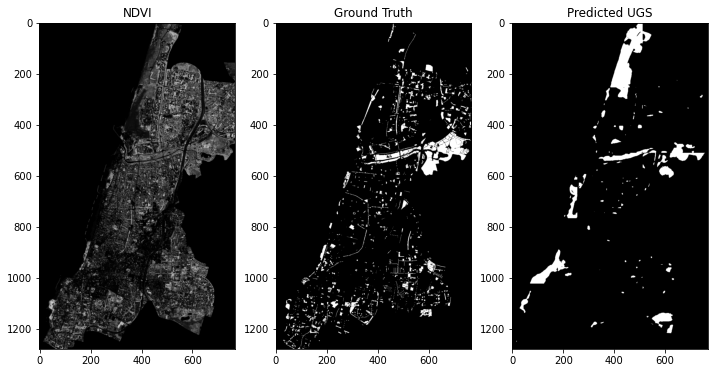

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title('NDVI')
plt.imshow(image_array_show[:, :, 0], cmap = 'gray')

plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(park_array_show[:, :, 0], cmap = 'gray')

plt.subplot(133)
plt.title('Predicted UGS')
plt.imshow(reconstructed_image_show, cmap = 'gray')


In [23]:
# get metadata of tif file
image = gdal.Open('/content/drive/MyDrive/ThesisProject/Data/TelAviv/bands_lst_ndbi_ndvi_ndwi_urban_r_g_b_nir_lc.tif')
geo_transform = image.GetGeoTransform()
originX = geo_transform[0]
originY = geo_transform[3]
pixelWidth = geo_transform[1]
pixelHeight = geo_transform[5]

In [24]:
import gdal, ogr, os, osr
import numpy as np

def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(32636)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()


def main(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):
    array2raster(newRasterfn, rasterOrigin, pixelWidth, pixelHeight, array) # convert array to raster

In [25]:
if __name__ == "__main__":
    rasterOrigin = (originX, originY)
    pixelWidth = pixelWidth
    pixelHeight = pixelHeight
    newRasterfn = 'test.tif'
    main(newRasterfn, rasterOrigin, pixelWidth, pixelHeight, reconstructed_image)